In [83]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import soundfile as sf
import IPython.display as ipd

## Señal de entrada a utilizar

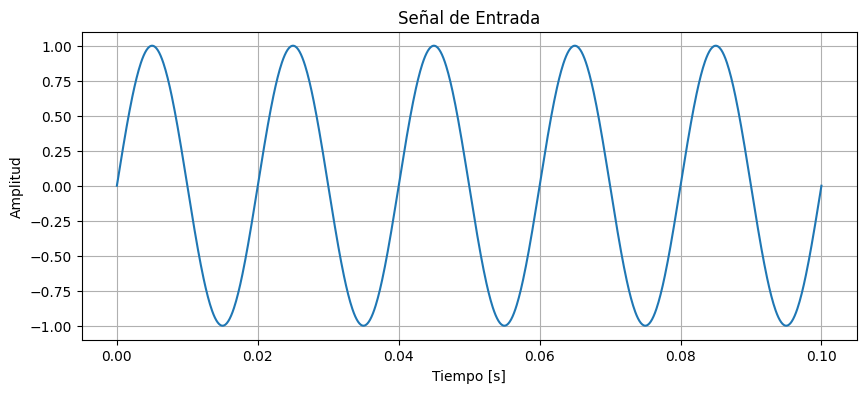

In [84]:
f = 50  # 50 Hz
omega = 2 * np.pi * f

t = np.linspace(0, 0.1, 1000)  # Tiempo de 0 a 0.1 segundos
input_signal = np.sin(omega * t)

plt.figure(figsize=(10, 4))
plt.plot(t, input_signal)
plt.title('Señal de Entrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

## Filtro RC Pasa Bajas

<img src="https://th.bing.com/th/id/R.52af8bc8442214bf138415f6dfcd6472?rik=mSkvDzsoh10r7g&pid=ImgRaw&r=0">

$$\frac{V_{out}}{V_{in}}=\frac{\frac{1}{sC}}{\frac{1}{sC}+R}=\frac{1}{1+sRC}$$            

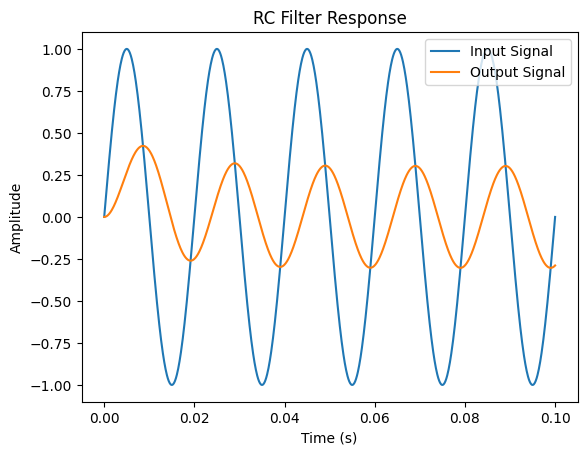

In [ ]:
def RC_filter(R_v, C_v, t, input_signal): # Parámetros: resistencia, capacitancia, tiempo y señal de entrada
    
    # Define symbolic variables
    s = sym.symbols('s')
    R = sym.symbols('R', positive=True)
    C = sym.symbols('C', positive=True)

    # Transfer function H(s) = 1 / (1 + sRC)
    H = 1 / (1 + s * R * C)

    num, den = sym.fraction(H)

    num_coeffs = sym.Poly(num, s).all_coeffs()
    den_coeffs = sym.Poly(den, s).all_coeffs() #Poly() Genera un polinomio a partir de una expresión, lo usamos para acceder a all_coeffs(). Genera una lista de listas con los coeficientes

    num_coeffs_num = []
    for coeff in num_coeffs:
        coeff_num = float(coeff.subs({R: R_v, C: C_v})) #Intercambiar las variables simbólicas por los valores numéricos
        num_coeffs_num.append(coeff_num)

    den_coeffs_num = []
    for coeff in den_coeffs:
        coeff_num = float(coeff.subs({R: R_v, C: C_v}))
        den_coeffs_num.append(coeff_num)

    # Crear el sistema LTI
    system = sig.lti(num_coeffs_num, den_coeffs_num)

    # Simular la respuesta del sistema a la señal de entrada
    return sig.lsim(system, input_signal, t)

R_v = 1000  # Valores de resistencia y capacitancia numéricos
C_v = 10e-6  

# Usar
t_out, y_out, _ = RC_filter(R_v, C_v, t, input_signal)

# Graficar
plt.plot(t, input_signal, label='Input Signal')
plt.plot(t_out, y_out, label='Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('RC Filter Response')
plt.legend()
plt.show()

## Sin sympy

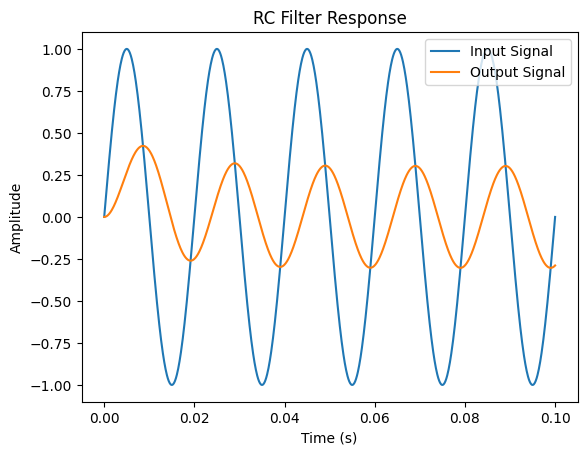

In [86]:
R_v = 1000 #Valores reales de los componentes
C_v = 10e-6

num = [1] #Coefecientes
den = [R_v * C_v, 1]

system = sig.lti(num, den) #Definir nuestro sistema LTI
t_out, y_out, _ = sig.lsim(system, U=input_signal, T=t)
plt.plot(t, input_signal, label='Input Signal')
plt.plot(t_out, y_out, label='Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('RC Filter Response')
plt.legend()
plt.show()

## Ahora con frecuencia de corte

$$fc = \frac{1}{2 \pi RC}$$

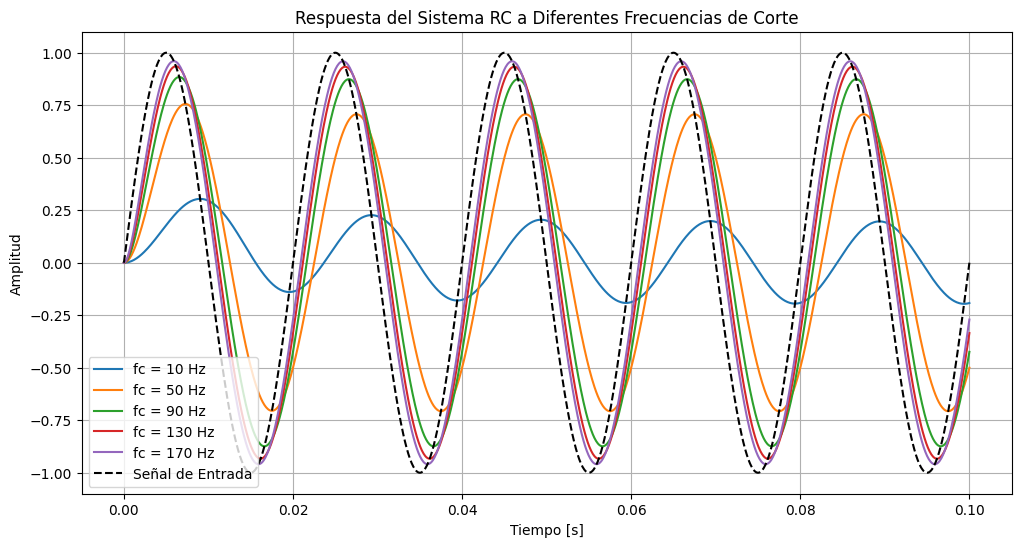

In [87]:
def RC_filter_fc(fc, t, input_signal):
    R_v = 1000 #Suponiendo R estática 1000 ohmios
    C_v =  1/(2*np.pi*fc*R_v)

    return RC_filter(R_v, C_v, t, input_signal)

# Frecuencias de corte para el filtro
f_cut = list(np.arange(10, 200, 40))

# Graficar la respuesta en el dominio del tiempo
plt.figure(figsize=(12, 6))
for i in f_cut:
    t_out, y_out, _ = RC_filter_fc(i, t, input_signal)
    plt.plot(t_out, y_out, label=f'fc = {i} Hz')

plt.plot(t, input_signal, label='Señal de Entrada', linestyle='--', color='k')
plt.title('Respuesta del Sistema RC a Diferentes Frecuencias de Corte')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()



## Diagrama de Bode del filtro RC

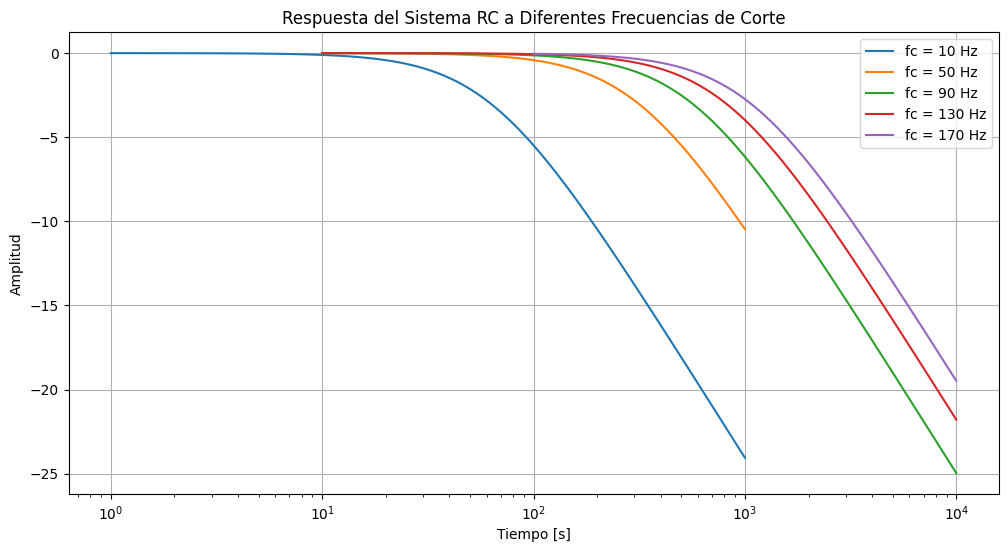

In [88]:
def bode_RC_filter(fc):
    s = sym.symbols('s')
    R = sym.symbols('R', positive=True)
    C = sym.symbols('C', positive=True)

    H = 1 / (1 + s * R * C)

    R_v = 1000
    C_v = 1/(2*np.pi*fc*R_v)

    num, den = sym.fraction(H)
    num_coeffs = sym.Poly(num, s).all_coeffs()
    den_coeffs = sym.Poly(den, s).all_coeffs()
    
    num_coeffs = [float(coeff.subs({R: R_v, C: C_v})) for coeff in num_coeffs] # Otra manera de hacerlo más rápido. Estudiar los for dentro de arrays [for idx in array]
    den_coeffs = [float(coeff.subs({R: R_v, C: C_v})) for coeff in den_coeffs]

    system = sig.lti(num_coeffs, den_coeffs)  # LTI system
    w, mag, phase = sig.bode(system) # Función para ver el diagrama de bode de un sistema

    return w, mag, phase


# Graficar la respuesta en el dominio del tiempo
plt.figure(figsize=(12, 6))
for i in f_cut:
    w, mag, _ = bode_RC_filter(i)
    plt.semilogx(w, mag, label=f'fc = {i} Hz')
plt.title('Respuesta del Sistema RC a Diferentes Frecuencias de Corte')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

## Filtrar archivo de audio

In [89]:
# Leer el archivo de audio
path = 'sounds/nature.mp3'

# Parámetros de inicio y fin del fragmento (en segundos)
t_i = 0  # Tiempo de inicio (segundos)
t_o = 5  # Tiempo de finalización (segundos)

# Abrir el archivo solo para obtener la frecuencia de muestreo
with sf.SoundFile(path) as audio:
    fs = audio.samplerate  # Frecuencia de muestreo
    print(f'Frecuencia de muestreo: {fs} Hz')

    # Calcular las posiciones de inicio y final en muestras
    start_sample = int(t_i * fs)
    stop_sample = int(t_o * fs)

    # Leer solo el fragmento deseado
    audio.seek(start_sample)  # Mover el puntero al inicio
    fragment = audio.read(frames=stop_sample - start_sample)

# Mostrar información del fragmento
print(f"Fragmento leído: {len(fragment)} muestras")
print(fragment.shape)

# Escuchar el audio extraído
ipd.Audio(fragment.T, rate=fs)  # Transponer fragment para que las muestras sean las columnas

Frecuencia de muestreo: 44100 Hz
Fragmento leído: 220500 muestras
(220500, 2)


In [90]:
x = fragment.copy()

x = np.mean(x, axis=1)  # Promedio de los canales (Audio mono)

t = np.arange(0, len(x)/fs, 1/fs)

# Pasar por filtro RC
fc = 4000

t_out, x_out, _ = RC_filter_fc(fc, t, x)

# Escuchar el audio filtrado
ipd.Audio(x_out.T, rate=fs)

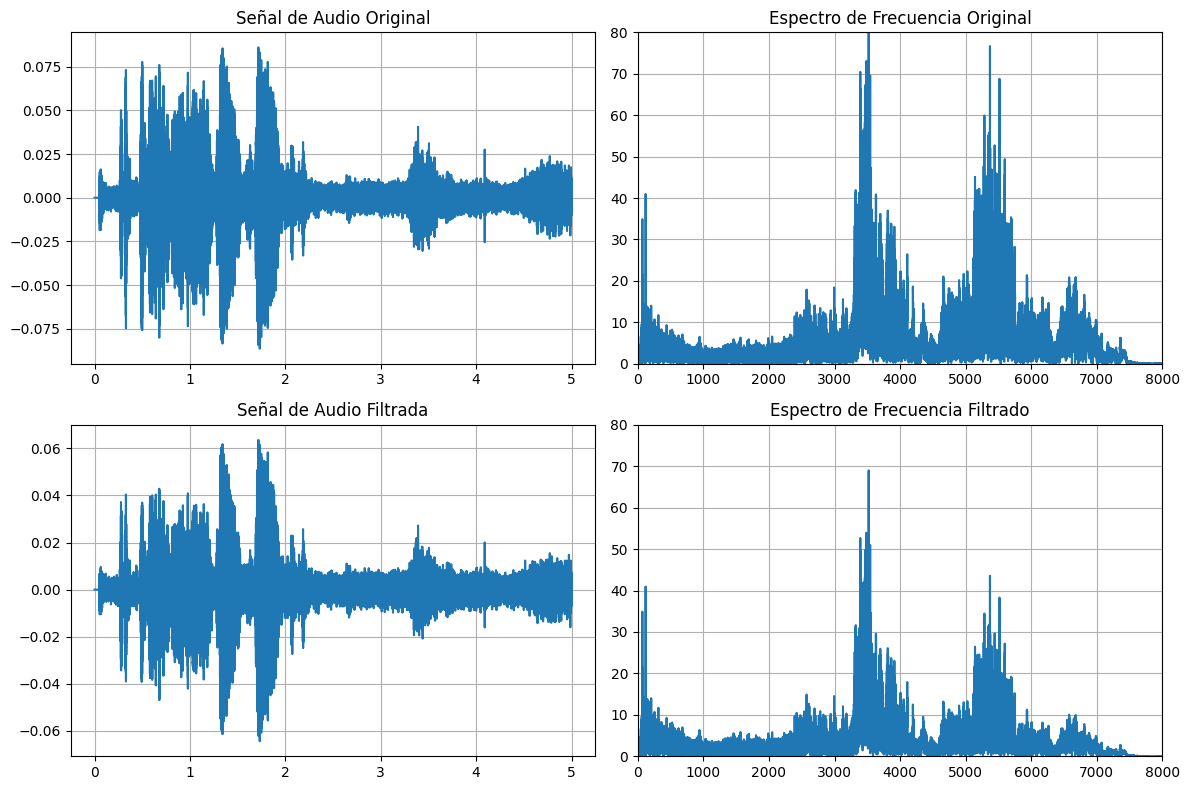

In [93]:
xw = np.fft.rfft(x)
freq = np.fft.rfftfreq(len(x), 1/fs)

xw_out = np.fft.rfft(x_out)
freq_out = np.fft.rfftfreq(len(x_out), 1/fs)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].plot(t, x)
axs[0,0].set_title('Señal de Audio Original')
axs[0,0].grid(True)

axs[0,1].plot(freq, np.abs(xw))
axs[0,1].set_title('Espectro de Frecuencia Original')
axs[0,1].grid(True)
axs[0,1].set_xlim([0, 8000])
axs[0,1].set_ylim([0, 80])

axs[1,0].plot(t_out, x_out)
axs[1,0].set_title('Señal de Audio Filtrada')
axs[1,0].grid(True)

axs[1,1].plot(freq_out, np.abs(xw_out))
axs[1,1].set_title('Espectro de Frecuencia Filtrado')
axs[1,1].grid(True)
axs[1,1].set_xlim([0, 8000])
axs[1,1].set_ylim([0, 80])
plt.tight_layout()
plt.show()

In [95]:
fcuts = np.arange(10, 5000, 500)

results = []
for pos, fc in enumerate(fcuts):
    t_out, x_out, _ = RC_filter_fc(fc, t, x)
    xw_out = np.fft.rfft(x_out)
    freq_out = np.fft.rfftfreq(len(x_out), 1/fs)
    results.append((freq_out, xw_out))
    print(f"{pos+1}/{len(fcuts)} - fc = {fc} Hz")
print("Done...")

1/10 - fc = 10 Hz
2/10 - fc = 510 Hz
3/10 - fc = 1010 Hz
4/10 - fc = 1510 Hz
5/10 - fc = 2010 Hz
6/10 - fc = 2510 Hz
7/10 - fc = 3010 Hz
8/10 - fc = 3510 Hz
9/10 - fc = 4010 Hz
10/10 - fc = 4510 Hz
Done...


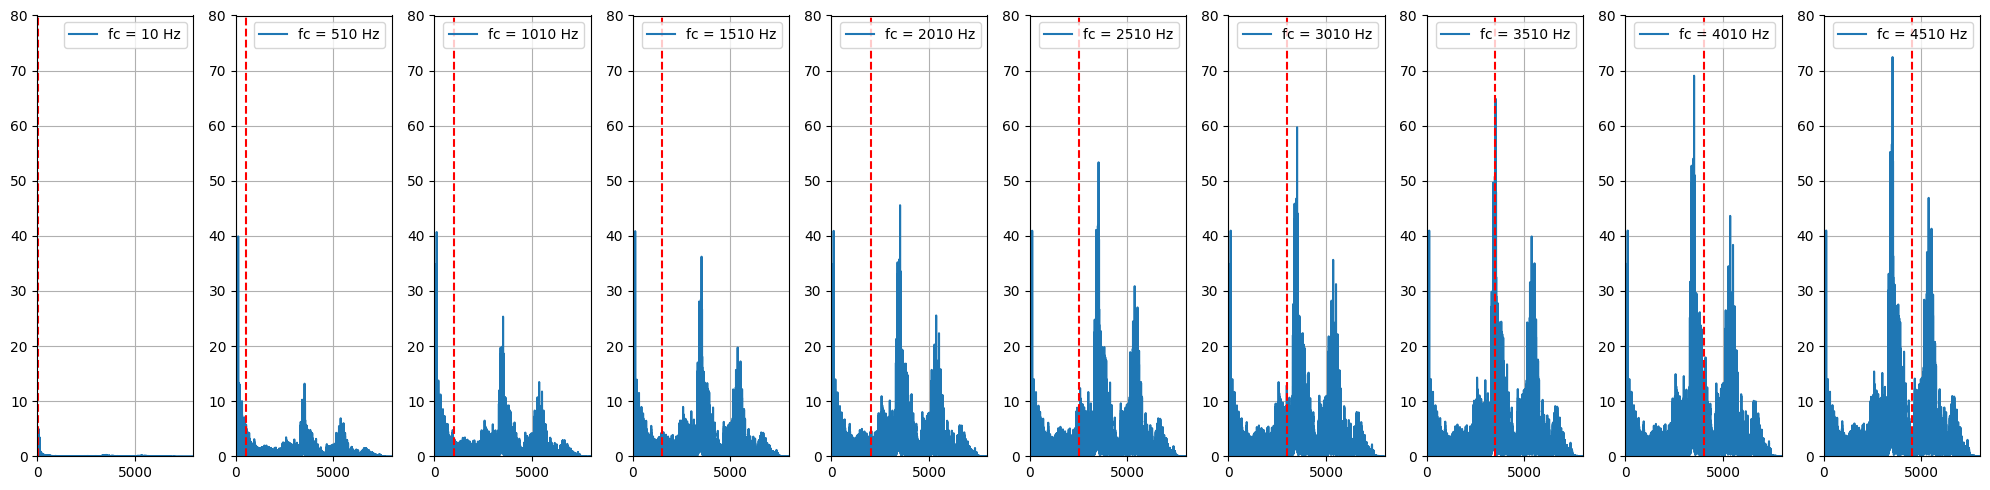

In [96]:
# Segundo bucle para la graficación
fig, axs = plt.subplots(1, len(fcuts), figsize=(20, 5))

for idx, (freq_out, xw_out) in enumerate(results):
    axs[idx].plot(freq_out, np.abs(xw_out), label=f'fc = {fcuts[idx]} Hz')
    axs[idx].axvline(x=fcuts[idx], color='r', linestyle='--')
    axs[idx].grid(True)
    axs[idx].set_xlim([0, 8000])
    axs[idx].set_ylim([0, 80])
    axs[idx].legend()

plt.tight_layout()
plt.show()